In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, Concatenate
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
from tensorflow.python.keras import layers

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
data_dir=r'/kaggle/input/2nd-replication/Total/'
for i,d in enumerate([data_dir]):
    filepaths=[]
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        classpath=os.path.join(d,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)                   
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    data_df=pd.concat([Fseries, Lseries], axis=1)
df=pd.concat([data_df], axis =0).reset_index(drop=True)# make a combined dataframe

print(df['labels'].value_counts())

t_resized_20    340
t_resized_22    340
t_resized_34    340
t_resized_36    340
t_resized_14    340
t_resized_12    340
t_resized_16    340
t_resized_26    340
t_resized_25    340
t_resized_1     340
t_resized_10    340
t_resized_27    340
t_resized_17    340
t_resized_28    340
t_resized_18    340
t_resized_29    340
t_resized_7     340
t_resized_8     340
t_resized_13    340
t_resized_11    340
t_resized_21    340
t_resized_30    340
t_resized_15    340
t_resized_23    340
t_resized_33    340
t_resized_3     340
t_resized_0     340
t_resized_9     340
t_resized_6     340
t_resized_31    340
t_resized_24    340
t_resized_35    340
t_resized_5     340
t_resized_32    340
t_resized_37    340
t_resized_19    340
t_resized_2     340
t_resized_4     340
Name: labels, dtype: int64


In [3]:
sample_size=340
sample_list=[]
group=df.groupby('labels')
for label in df['labels'].unique():    
    label_group=group.get_group(label).sample(sample_size, replace=False, random_state=123, axis=0)    
    sample_list.append(label_group)
df=pd.concat(sample_list, axis=0).reset_index(drop=False)
print (len(df))

12920


In [4]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), ' test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  10336  test_df length:  1292   valid_df length:  1292


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height=224
width=224
channels=3
batch_size=16
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
valid_classes=list(valid_gen.class_indices.keys())
class_count=len(classes)

test batch size:  76   test steps:  17
Found 10336 validated image filenames belonging to 38 classes.
Found 1292 validated image filenames belonging to 38 classes.
Found 1292 validated image filenames belonging to 38 classes.


In [6]:
from tensorflow.keras.utils import to_categorical
print(classes)
print(valid_classes)

['t_resized_0', 't_resized_1', 't_resized_10', 't_resized_11', 't_resized_12', 't_resized_13', 't_resized_14', 't_resized_15', 't_resized_16', 't_resized_17', 't_resized_18', 't_resized_19', 't_resized_2', 't_resized_20', 't_resized_21', 't_resized_22', 't_resized_23', 't_resized_24', 't_resized_25', 't_resized_26', 't_resized_27', 't_resized_28', 't_resized_29', 't_resized_3', 't_resized_30', 't_resized_31', 't_resized_32', 't_resized_33', 't_resized_34', 't_resized_35', 't_resized_36', 't_resized_37', 't_resized_4', 't_resized_5', 't_resized_6', 't_resized_7', 't_resized_8', 't_resized_9']
['t_resized_0', 't_resized_1', 't_resized_10', 't_resized_11', 't_resized_12', 't_resized_13', 't_resized_14', 't_resized_15', 't_resized_16', 't_resized_17', 't_resized_18', 't_resized_19', 't_resized_2', 't_resized_20', 't_resized_21', 't_resized_22', 't_resized_23', 't_resized_24', 't_resized_25', 't_resized_26', 't_resized_27', 't_resized_28', 't_resized_29', 't_resized_3', 't_resized_30', 't_r

In [7]:
IMG_SIZE=224

In [8]:
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.layers import Concatenate, Dense, Input,ZeroPadding2D, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall,Precision

In [9]:
num_classes=len(classes)
print(num_classes)

38


In [10]:
from tensorflow.keras.metrics import Recall, Precision

In [11]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, Flatten, Activation, MaxPooling2D, concatenate



In [12]:
def model(input_shape=[224,224, 3]):
    #base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    
    base_model = MobileNet(weights='imagenet', include_top=False,input_shape= input_shape)
    for layer in base_model.layers:
        layer.trainable = True
    x = base_model.output
    
    
    
    y= Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    y=Conv2D(64,(3,3), padding='same', activation='relu' )(y)
    y=BatchNormalization()(y)
    y=Activation('relu')(y)
    #y=MaxPooling2D(pool_size=(2, 2))(y)
    y=Dropout(0.25)(y)


    y=Conv2D(128,(5,5), padding='same', activation='relu')(y)
    y=BatchNormalization()(y)
    y=Activation('relu')(y)
    #y=MaxPooling2D(pool_size=(2, 2))(y)
    y=Dropout(0.25)(y)


    y=Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(y)
    y=BatchNormalization()(y)
    y=Activation('relu')(y)
    #y=MaxPooling2D(pool_size=(2, 2))(y)
    y=Dropout(0.25)(y)


    y=Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(y)
    y=BatchNormalization()(y)
    y=Activation('relu')(y)
    y=Dropout(0.25)(y)

    #Faltten the model
    y=Flatten()(y)


    y=Dense(256)(y)
    y=BatchNormalization()(y)
    y=Activation('relu')(y)
    y=Dropout(0.25)(y)


    y=Dense(512)(y)
    y=BatchNormalization()(y)
    y=Activation('relu')(y)
    y=Dropout(0.25)(y)

    y=Dense(64)(y)
    y=BatchNormalization()(y)
    y=Activation('relu')(y)

    

    

 

    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(38, activation='softmax')(y)
    model = Model(inputs= base_model.input, outputs=predictions)
    return model


    
    

In [13]:
model = model()

2023-02-07 09:31:57.163569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 09:31:57.164602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 09:31:57.353105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 09:31:57.353982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 09:31:57.354811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

17235968/17225924 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [15]:
model.compile(Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

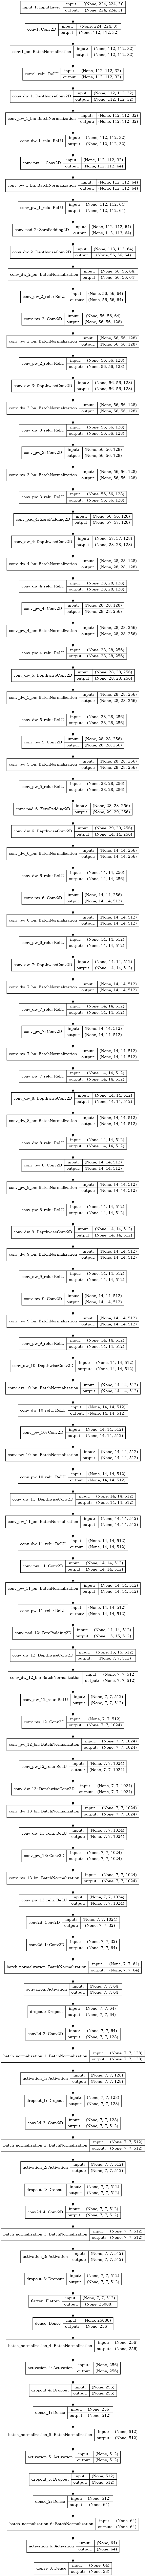

In [16]:
from keras.utils.vis_utils import plot_model
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

plot_model(model, to_file='model.png', show_shapes=True)

In [17]:
model_name='Own'

In [18]:
from tensorflow.python.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor= 'loss', patience=5,mode = 'min' ,verbose=1)

In [19]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [20]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now        
        if epoch== self.initial_epoch or LRA.reset==True:  
            LRA.reset=False           
            msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^11s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy','V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
            print_in_color(msg, (244,252,3), (55,65,80)) 
            
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
                    msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
                    print_in_color (msg,(0, 67, 54), (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

In [21]:
epochs =110
patience= 15 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell,model_name= model_name,  freeze=freeze, initial_epoch=0 )]
LRA.tepochs=epochs  # used to determine value of last epoch for printing
history=model.fit(train_gen,  epochs=epochs, callbacks=callbacks, verbose=1,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model Own training all layers 



2023-02-07 09:32:05.869948: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/110


2023-02-07 09:32:11.488936: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


646/646 [==============================] - 107s 140ms/step - loss: 4.6429 - accuracy: 0.2119 - precision: 0.5908 - recall: 0.0173 - val_loss: 1.8072 - val_accuracy: 0.4590 - val_precision: 0.6623 - val_recall: 0.1548
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

Epoch 2/110
646/646 [==============================] - 77s 119ms/step - loss: 1.7832 - accuracy: 0.4658 - precision: 0.6803 - recall: 0.1871 - val_loss: 2.4682 - val_accuracy: 0.4164 - val_precision: 0.4515 - val_recall: 0.3390
Epoch 3/110
646/646 [==============================] - 78s 121ms/step - loss: 1.4043 - accuracy: 0.6114 - precision: 0.7551 - recall: 0.4401 - val_loss: 1.2669 - val_accuracy: 0.6734 - val_precision: 0.7728 - val_recall: 0.5898
Epoch 4/110
646/646 [==============================] - 77s 118ms/step - loss: 1.1889 - accuracy: 0.7003 - precision: 0.7993 - recall: 0.5891 - val_loss: 1.2439 - val_accuracy: 0.7159 - val_precision: 0.8010 - val_recall: 0.6324
Epoch 5/110
646

In [22]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [23]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 38:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

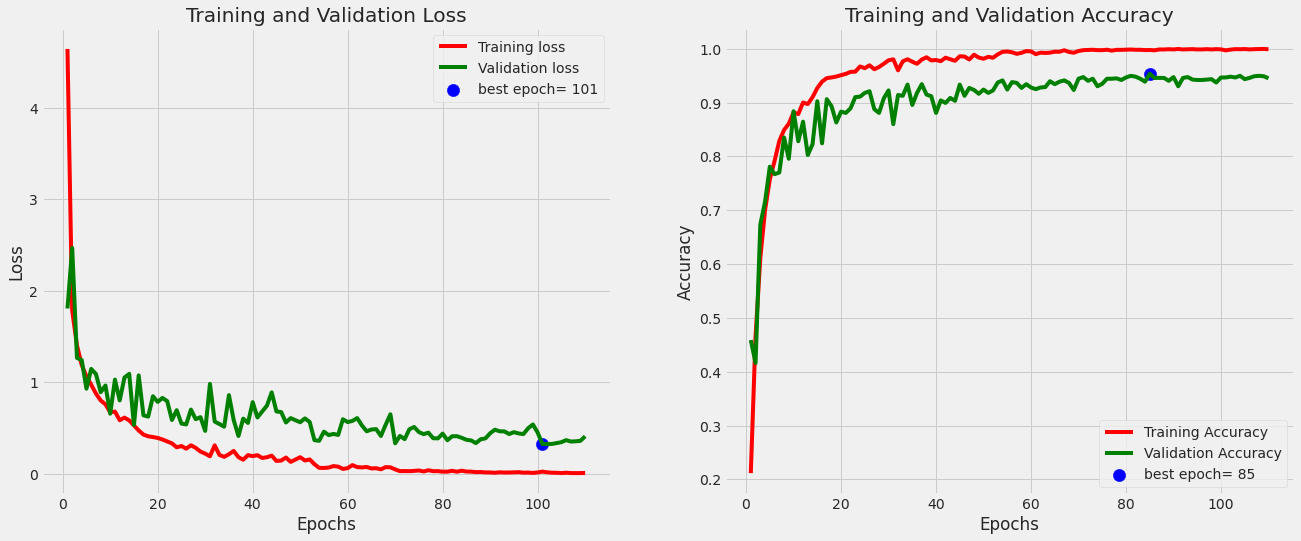

17/17 [==============================] - 12s 665ms/step - loss: 0.3416 - accuracy: 0.9574 - precision: 0.9581 - recall: 0.9567
accuracy on the test set is 95.74 %



In [24]:
tr_plot(history,0)
save_dir=r'./'
subject='fruits'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

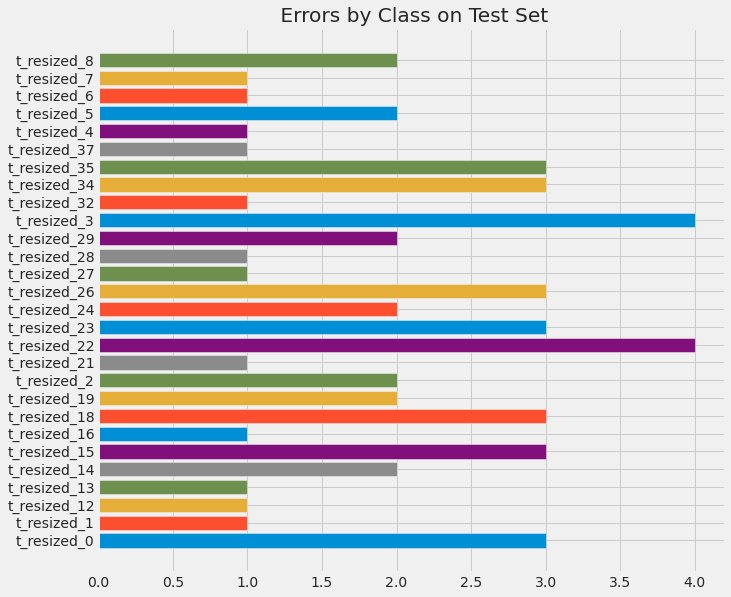

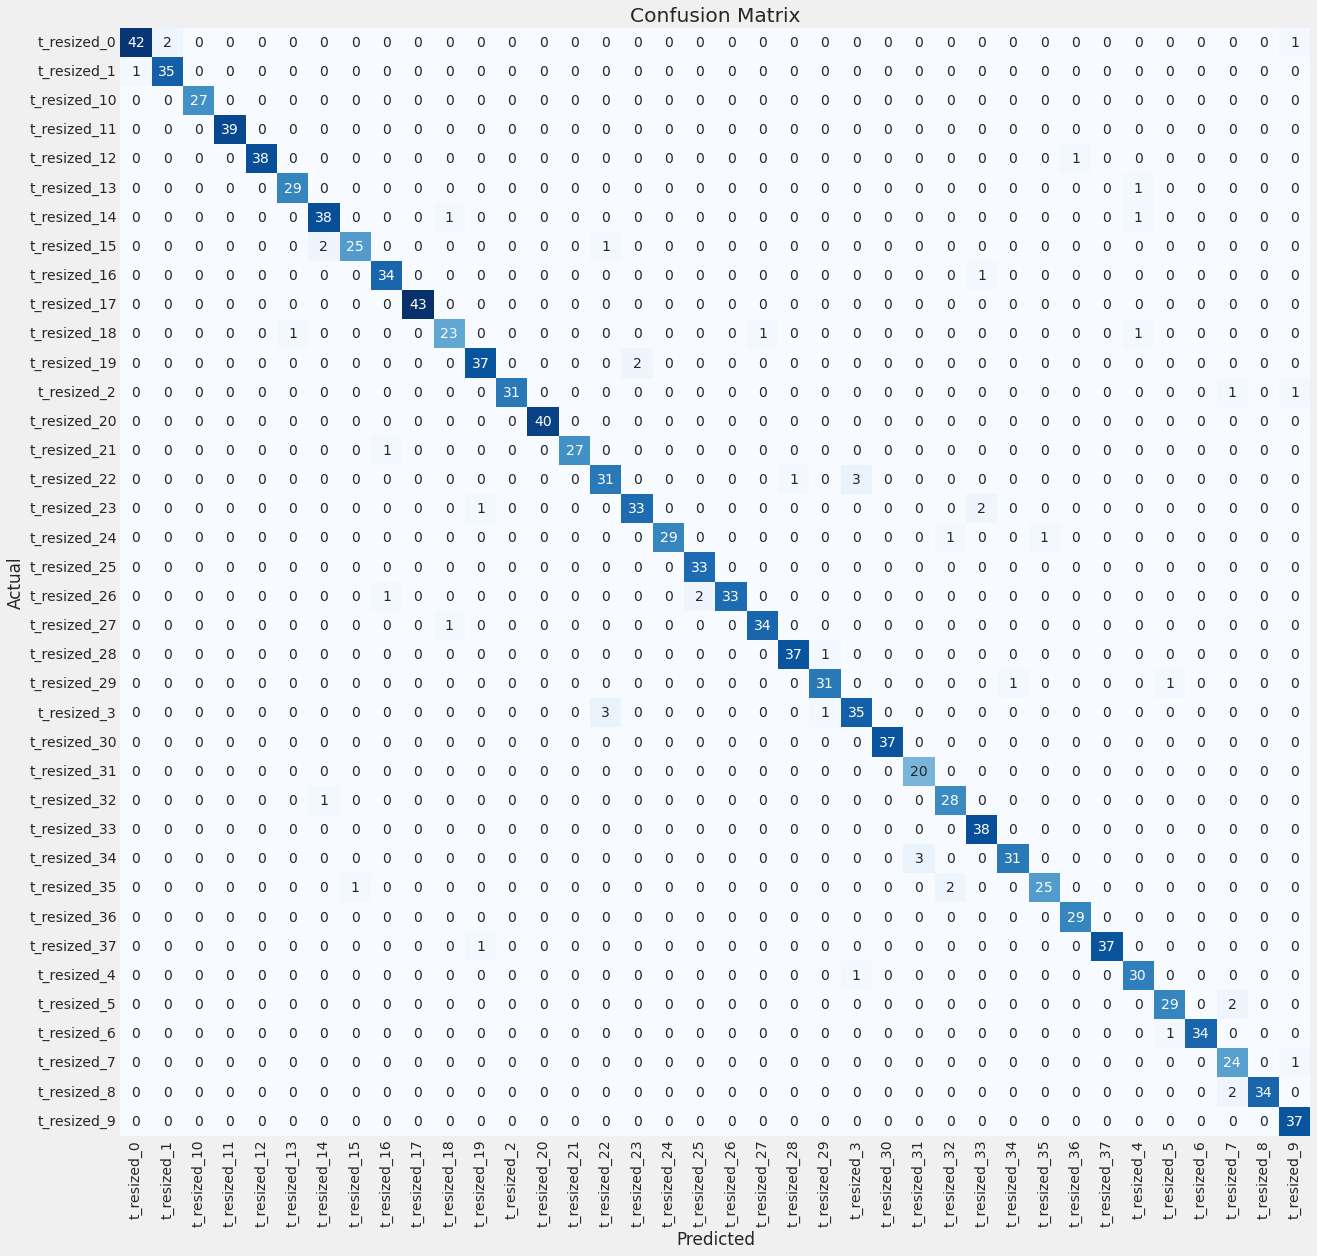

Classification Report:
----------------------
               precision    recall  f1-score   support

 t_resized_0       0.98      0.93      0.95        45
 t_resized_1       0.95      0.97      0.96        36
t_resized_10       1.00      1.00      1.00        27
t_resized_11       1.00      1.00      1.00        39
t_resized_12       1.00      0.97      0.99        39
t_resized_13       0.97      0.97      0.97        30
t_resized_14       0.93      0.95      0.94        40
t_resized_15       0.96      0.89      0.93        28
t_resized_16       0.94      0.97      0.96        35
t_resized_17       1.00      1.00      1.00        43
t_resized_18       0.92      0.88      0.90        26
t_resized_19       0.95      0.95      0.95        39
 t_resized_2       1.00      0.94      0.97        33
t_resized_20       1.00      1.00      1.00        40
t_resized_21       1.00      0.96      0.98        28
t_resized_22       0.89      0.89      0.89        35
t_resized_23       0.94      0.92 

In [25]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject ) 